# Protein Classificator

## Importing required packages

In [ ]:
!pip3.7 install biopython

     |████████████████████████████████| 2.3 MB 10.6 MB/s 


In [ ]:
 !pip3.7 install fair-esm

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy

from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

Command to run to open data files in Google Colab environment.

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/proteomes/
  inflating: data/proteomes/UP000001974_273057.fasta  
  inflating: data/proteomes/UP000000625_83333.fasta  
   creating: data/FASTA/
  inflating: data/FASTA/training_sequences_sample.fasta  
  inflating: data/FASTA/filtered_testing_sequences.fasta  
  inflating: data/FASTA/.DS_Store    
  inflating: data/FASTA/filtered_training_sample_sequences.fasta  
  inflating: data/FASTA/testing_sequences.fasta  
  inflating: data/FASTA/training_sequences.fasta  
  inflating: data/FASTA/validation_sequences.fasta  
  inflating: data/FASTA/filtered_validation_sequences.fasta  
  inflating: data/FASTA/filtered_training_sequences.fasta  
   creating: data/CSV/
  inflating: data/CSV/validation_temperature_annotations.csv  
  inflating: data/CSV/testing_temperature_annotations.csv  
  inflating: data/CSV/training_temperature_annotations.csv  
   creating: data/visualisation/
  inflating: data/visua

## Configuration of temperature labels and input files

In [ ]:
temperature_labels_full = [37, 80]

files = ['data/proteomes/UP000000625_83333.fasta', 'data/proteomes/UP000001974_273057.fasta']

## Splitting the dataset for training, validation and testing

The proportions for splitting were chosen to be 70%, 15% and 15% for training, validation and testing respectively.

In [ ]:
# Initialisation of the dataset container
data = {
    'train': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/training_',
        'CSV_prefix': 'data/CSV/training_',
    },
    'validate': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/validation_',
        'CSV_prefix': 'data/CSV/validation_'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/testing_',
        'CSV_prefix': 'data/CSV/testing_'
    }
}

# Removing duplicate sequences in the dataset
seen = set()

for i in range(len(temperature_labels_full)):
    records = [] 
    # Parsing sequences (X dataset) from one dataset 
    for record in SeqIO.parse(files[i], "fasta"):
        if record.seq not in seen:
            seen.add(record.seq)
            records.append(record)

    # Creating Y dataset from temperature labels 
    temperature_labels = [temperature_labels_full[i]] * len(records)

    # Spliting the dataset to 70% (training) and 30% (trying)
    X_train, X_try, Y_train, Y_try = train_test_split(records, temperature_labels, test_size=0.3, shuffle=True, random_state=1)

    # Splitting 30% from the initial set in half for calidation and testing
    X_validate, X_test, Y_validate, Y_test = train_test_split(X_try, Y_try, test_size=0.5, shuffle=True, random_state=1)

    data['train']['X'] = data['train']['X'] + X_train
    data['train']['Y'] = data['train']['Y'] + Y_train
    data['validate']['X'] = data['validate']['X'] + X_validate
    data['validate']['Y'] = data['validate']['Y'] + Y_validate
    data['test']['X'] = data['test']['X'] + X_test
    data['test']['Y'] = data['test']['Y'] + Y_test

# Shuffling the datasets
for element in data.keys():
    data[element]['X'], data[element]['Y'] = shuffle(data[element]['X'], data[element]['Y'], random_state=1)



## Checking the success of parsing

In [ ]:
print(len(seen))
print(len(data['train']['X']))
print(len(data['validate']['X']))
print(len(data['test']['X']))

7288
5101
1093
1094


## Checking the maximum length

In [ ]:
max_length = 0
max_length_seq = None

for element in data.keys():
    for i in range(len(data[element]['X'])):
        if(len(data[element]['X'][i].seq) > max_length):
            max_length = len(data[element]['X'][i].seq)
            max_length_seq = data[element]['X'][i]

print(max_length)
print(max_length_seq)

2358
ID: sp|P76347|YEEJ_ECOLI
Name: sp|P76347|YEEJ_ECOLI
Description: sp|P76347|YEEJ_ECOLI Uncharacterized protein YeeJ OS=Escherichia coli (strain K12) OX=83333 GN=yeeJ PE=3 SV=3
Number of features: 0
Seq('MATKKRSGEEINDRQILCGMGIKLRRLTAGICLITQLAFPMAAAAQGVVNAATQ...KNL')


## Creating files 

`[training|validation|testing]_sequences.fasta`

In [ ]:
# Creating data/FASTA/*_sequences.fasta files

for element in data.keys():
    file_name = data[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for record in data[element]['X']:
        file_handle.write('>'+record.name.split('|')[1])
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

  `[training|validation|testing]_temperature_annotations.csv`

In [ ]:
# Creating data/*_temperature_annotations.csv files

for element in data.keys():
    file_name = data[element]['CSV_prefix']+'temperature_annotations.csv'
    file_handle = open(file_name, 'w')
    file_handle.write('identifier,label'+"\n")
    for i in range(len(data[element]['X'])):
        file_handle.write(data[element]['X'][i].name.split('|')[1]+','+str(data[element]['Y'][i]))
        file_handle.write("\n")
    file_handle.close()

## Filtering sequences from initial FASTA files 

Since the visualisation is not allowed without embedding for each FASTA sequence, it was required to filter all sequences and keep only those that have their embeddings.

In [ ]:
data_filtered = {
    'train': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_training_',
        'CSV_prefix': 'data/CSV/filtered_training_',
        'embedding_list': './data/EMB_ESM1b/training_embeddings_sample.lst',
        'embeddings': '/content/drive/MyDrive/training_embeddings_sample'
    },
    'validate': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_validation_',
        'CSV_prefix': 'data/CSV/filtered_validation_',
        'embedding_list': './data/EMB_ESM1b/validation_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/validation_sequences'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/filtered_testing_',
        'CSV_prefix': 'data/CSV/filtered_testing_',
        'embedding_list': './data/EMB_ESM1b/testing_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/testing_sequences'
    }
}

for element in data.keys():
    emb_list_handle = open(data_filtered[element]['embedding_list'], 'r')
    emb_list = emb_list_handle.readlines()
    emb_list_handle.close()
    emb_set = set()
    for j in range(len(emb_list)):
        emb_set.add(emb_list[j].split('.')[0])
    for i in range(len(data[element]['X'])):
        if(data[element]['X'][i].id.split('|')[1] in emb_set):
            data_filtered[element]['X'].append(data[element]['X'][i])
            data_filtered[element]['Y'].append(data[element]['Y'][i])


Testing, whether the filtration was successful.

In [ ]:
print(len(data_filtered['train']['X']))
print(len(data_filtered['validate']['X']))
print(len(data_filtered['test']['X']))

1264
1079
1080


## Creating filtered FASTA files

In [ ]:
# Creating data/FASTA/filtered_*_sequences.fasta files

for element in data_filtered.keys():
    file_name = data_filtered[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for i in range(len(data_filtered[element]['X'])):
    #for i in range(5):
        #file_handle.write('>'+record.name.split('|')[1])
        file_handle.write('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        #print('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

## Fetching data of embeddings 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualisation of embeddings

In [ ]:
!pip3.7 install pymde

     |████████████████████████████████| 139 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 46.1 MB/s 
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=172c0c6be2ce5957ee1fcaafc1dd4a905b10850e1bf63222bf835534fc24c785
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built pynndescent


### Visualisation of training dataset sample embeddings

In [16]:
Ys = []
Xs = []

keys = ['train']

for key in keys:
    FASTA_PATH = 'data/FASTA/filtered_training_sample_sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

In [13]:
import esm
import torch
import pymde
from matplotlib import colors
from matplotlib.colors import ListedColormap

EMB_LAYER = 33

In [14]:
custom_cmap = ListedColormap(["navy", "pink"])

In [15]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs)

NameError: ignored

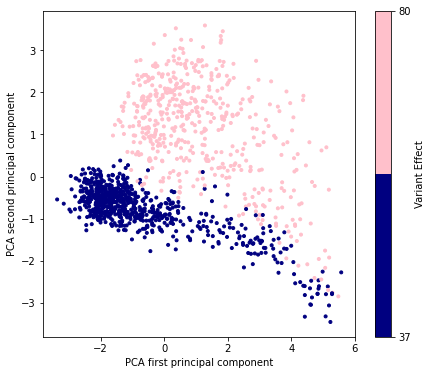

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=Ys, marker='.', cmap=custom_cmap)
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect', ticks=numpy.linspace(37, 80, 2))
plt.savefig('training_sample_visualisation_matplotlib.png')

In [17]:
Xs_torch_train = None

Xs_torch_train = torch.from_numpy(Xs)

embedding_train = pymde.preserve_neighbors(Xs_torch_train).embed(verbose=True)

Nov 24 04:17:45 AM: Fitting a centered embedding into R^2, for a graph with 1264 items and 12116 edges.
Nov 24 04:17:45 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 04:17:45 AM: iteration 000 | distortion 0.619481 | residual norm 0.213299 | step length 0.202188 | percent change 0.085774
Nov 24 04:17:45 AM: iteration 030 | distortion 0.207236 | residual norm 0.00174316 | step length 1 | percent change 1.52646
Nov 24 04:17:45 AM: iteration 060 | distortion 0.200344 | residual norm 0.000935586 | step length 1 | percent change 0.334692
Nov 24 04:17:45 AM: iteration 090 | distortion 0.199520 | residual norm 0.000526487 | step length 1 | percent change 0.1968
Nov 24 04:17:46 AM: iteration 120 | distortion 0.199001 | residual norm 0.000494145 | step length 1 | percent change 0.0902105
Nov 24 04:17:46 AM: iteration 150 | distortion 0.198627 | residual norm 0.000654554 | step length 1 | percent change 0.275757
Nov 24 04:17:46 AM: iteration 180 | distortion 0.1

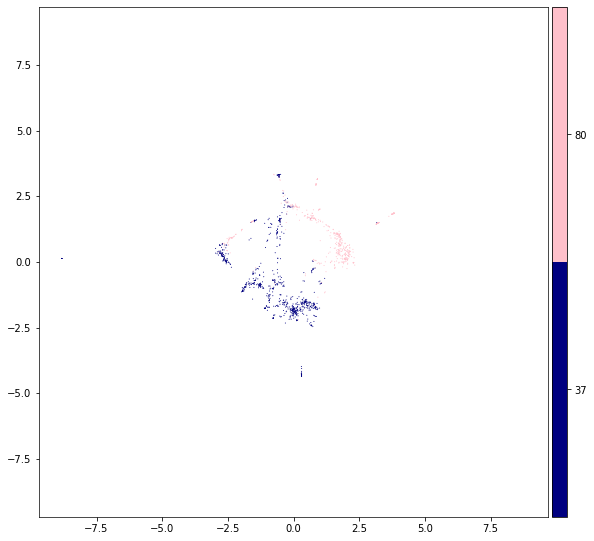

In [18]:
pymde.plot(embedding_train, color_by=Ys, savepath='training_sample_visualisation_PyMDE.png', color_map=custom_cmap)

### Visualisation of validation and testing dataset embeddings

In [25]:
Ys = []
Xs = []

keys = ['validate', 'test']

for key in keys:
    FASTA_PATH = data_filtered[key]['FASTA_prefix']+'sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()


Testing the parsing.

In [ ]:
print(len(Ys))
print(Xs.shape)

1264
(1264, 1280)


In [ ]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs)

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=Ys, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect', ticks=numpy.linspace(37, 80, 2))
plt.savefig('validation_and_testing_sequences_visualisation_matplotlib.png')

In [26]:
Xs_torch_validate = torch.from_numpy(Xs)

embedding = pymde.preserve_neighbors(Xs_torch_validate).embed(verbose=True)

Nov 24 04:38:45 AM: Fitting a centered embedding into R^2, for a graph with 1079 items and 8666 edges.
Nov 24 04:38:45 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 04:38:45 AM: iteration 000 | distortion 1.442911 | residual norm 7.53011 | step length 0.0107889 | percent change 0.174885
Nov 24 04:38:45 AM: iteration 030 | distortion 0.230945 | residual norm 0.00364484 | step length 1 | percent change 1.61362
Nov 24 04:38:45 AM: iteration 060 | distortion 0.212735 | residual norm 0.0016108 | step length 1 | percent change 0.519119
Nov 24 04:38:46 AM: iteration 090 | distortion 0.205151 | residual norm 0.00107397 | step length 1 | percent change 0.680107
Nov 24 04:38:46 AM: iteration 120 | distortion 0.201872 | residual norm 0.000999554 | step length 1 | percent change 0.622068
Nov 24 04:38:46 AM: iteration 150 | distortion 0.200445 | residual norm 0.000800306 | step length 1 | percent change 0.538189
Nov 24 04:38:46 AM: iteration 180 | distortion 0.1996

In [ ]:
pymde.plot(embedding, color_by=Ys, savepath='validation_and_testing_sequences_visualisation_PyMDE.png')

-------------------------------------------

## Perceptron

Based on: 

https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/

### Preparing data 

In [29]:
Ys_train = []
Xs_train = []

keys = ['train']

for key in keys:
    FASTA_PATH = 'data/FASTA/filtered_training_sample_sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys_train.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs_train.append(embs['mean_representations'][EMB_LAYER])

Xs_train = torch.stack(Xs_train, dim=0).numpy()

Xs_torch_train = None

Xs_torch_train = torch.from_numpy(Xs_train)

embedding_train = pymde.preserve_neighbors(Xs_torch_train).embed(verbose=True)

Nov 24 04:44:28 AM: Fitting a centered embedding into R^2, for a graph with 1264 items and 12113 edges.
Nov 24 04:44:28 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 04:44:28 AM: iteration 000 | distortion 0.621155 | residual norm 0.296333 | step length 0.202519 | percent change 0.11936
Nov 24 04:44:28 AM: iteration 030 | distortion 0.209800 | residual norm 0.00216512 | step length 1 | percent change 0.751988
Nov 24 04:44:29 AM: iteration 060 | distortion 0.203650 | residual norm 0.000869072 | step length 1 | percent change 0.426131
Nov 24 04:44:29 AM: iteration 090 | distortion 0.202340 | residual norm 0.000705438 | step length 1 | percent change 0.207831
Nov 24 04:44:29 AM: iteration 120 | distortion 0.201834 | residual norm 0.000532199 | step length 1 | percent change 0.152193
Nov 24 04:44:29 AM: iteration 150 | distortion 0.201033 | residual norm 0.000536021 | step length 1 | percent change 0.237245
Nov 24 04:44:29 AM: iteration 180 | distortion 0.

In [30]:
Ys_validate = []
Xs_validate = []

keys = ['validate']

for key in keys:
    FASTA_PATH = data_filtered[key]['FASTA_prefix']+'sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys_validate.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs_validate.append(embs['mean_representations'][EMB_LAYER])

Xs_validate = torch.stack(Xs_validate, dim=0).numpy()

Xs_torch_validate = torch.from_numpy(Xs_validate)

embedding = pymde.preserve_neighbors(Xs_torch_validate).embed(verbose=True)

Nov 24 04:47:12 AM: Fitting a centered embedding into R^2, for a graph with 1079 items and 8659 edges.
Nov 24 04:47:12 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 04:47:12 AM: iteration 000 | distortion 1.448179 | residual norm 5.38877 | step length 0.0124552 | percent change 0.144483
Nov 24 04:47:12 AM: iteration 030 | distortion 0.224528 | residual norm 0.00424083 | step length 1 | percent change 0.949574
Nov 24 04:47:13 AM: iteration 060 | distortion 0.205603 | residual norm 0.00156474 | step length 1 | percent change 1.03784
Nov 24 04:47:13 AM: iteration 090 | distortion 0.201581 | residual norm 0.000854205 | step length 1 | percent change 0.457567
Nov 24 04:47:13 AM: iteration 120 | distortion 0.199219 | residual norm 0.000860707 | step length 1 | percent change 0.668821
Nov 24 04:47:13 AM: iteration 150 | distortion 0.198630 | residual norm 0.00094883 | step length 1 | percent change 0.100677
Nov 24 04:47:13 AM: iteration 180 | distortion 0.197

In [33]:
# Preparing labels' data for training.
Ys_array_train = numpy.asarray(Ys_train)
Ys_torch_train = torch.from_numpy(Ys_array_train)

# Preparing labels' data for validation.
Ys_array_validate = numpy.asarray(Ys)
Ys_torch_validate = torch.from_numpy(Ys_array_validate)

In [34]:
print(Xs_torch_train.shape)
print(Ys_torch_train.shape)

print(Xs_torch_validate.shape)
print(Ys_torch_validate.shape)

torch.Size([1264, 1280])
torch.Size([1264])
torch.Size([1079, 1280])
torch.Size([1079])


### Defining functions

The weights and biases need to be initialized for the model. There are as many weights as dimensions in the input (embedding).

We will initialize weights with random numbers from -0.5 to 0.5.

In [41]:
import random

def get_initialized_weights(X):
    number_of_weights = len(X[0])
    weights = []
    for i in range(number_of_weights):
        weights.append(random.uniform(-0.5, 0.5))
    return weights

def activation(X, weights, bias):
    activation = bias
    for i in range(len(X)):
        activation += weights[i] * X[i]
    return activation

def predict(X, weights, bias):
    activ = activation(X, weights, bias)
    return 80 if(activ > 0) else 37

# Function to train network weights using a stochastic gradient descent.
def train_weights(Xs, Ys, weights, bias, learning_rate, number_of_epochs):
    for i in range(number_of_epochs):
        sum_error = 0.0
        for j in range(len(Xs)):
            prediction = predict(Xs[i], weights, bias)
            error = Ys[i] - prediction
            sum_error += error**2
            bias = bias + learning_rate * error
            for k in range(len(weights)):
                weights[j] = weights[j] + learning_rate * error * Xs[j][k]
        print('>epoch=%d, learning_rate=%.3f, error=%.3f' % (i, learning_rate, sum_error))
    return [weights, bias]

def get_accuracy(predictions, Ys):
    match_sum = 0
    for i in range(len(predictions)):
        if(predictions[i] == Ys[i].item()):
            match_sum += 1
    return (match_sum/len(predictions))*100

def get_predictions(Xs, weights, bias):
    predictions = []
    for i in range(len(Xs)):
        predictions.append(predict(Xs[i], weights, bias))
    return predictions

### Checking prediction accuracy of an untrained perceptron.

In [36]:
random.seed(1)

weights = get_initialized_weights(Xs_torch_train)
bias = -0.1

match_sum = 0
for i in range(len(Xs_torch_train)):
    if(predict(Xs_torch_train[i], weights, bias) == Ys_torch_train[i].item()):
        match_sum += 1

# Accuracy
print('Accuracy with randomly initialized weights:', match_sum/len(Xs_torch_train))

Accuracy with randomly initialized weights: 0.5941455696202531


### Training 

In [37]:
learning_rate = 0.1
number_of_epochs = 5
[weights, bias] = train_weights(Xs_torch_train, Ys_torch_train, weights, bias, learning_rate, number_of_epochs)

>epoch=0, learning_rate=0.100, error=59168.000
>epoch=1, learning_rate=0.100, error=0.000
>epoch=2, learning_rate=0.100, error=281048.000
>epoch=3, learning_rate=0.100, error=0.000
>epoch=4, learning_rate=0.100, error=0.000


### Validating the trained model

In [42]:
predictions = get_predictions(Xs_torch_validate, weights, bias)
print(get_accuracy(predictions, Ys_torch_validate))

59.49953660797034
